# Tema 2 – Partea 2: Analiza de Sentiment (RO)



## 1. EDA
- identificarea semnalelor utile pentru clasificare
- decizii informate pt tokenizare, vocab, max_len, padding, OOV, augmentări

In [ ]:
import re
import os
import math
import random
import numpy as np
import pandas as pd

from collections import Counter, defaultdict

import matplotlib.pyplot as plt

import seaborn as sns

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

pd.set_option("display.max_colwidth", 120)


In [2]:
TRAIN_URL = "https://raw.githubusercontent.com/dumitrescustefan/Romanian-Transformers/examples/examples/sentiment_analysis/ro/train.csv"
TEST_URL  = "https://raw.githubusercontent.com/dumitrescustefan/Romanian-Transformers/examples/examples/sentiment_analysis/ro/test.csv"

train_df = pd.read_csv(TRAIN_URL)
test_df  = pd.read_csv(TEST_URL)

label_map = {0: "negative", 1: "positive"}

print(train_df.shape, test_df.shape)
train_df.head()

(17941, 3) (11005, 3)


,index,text,label
0,0,acest document mi-a deschis cu adevarat ochii la ceea ce oamenii din afara statelor unite s-au gandit la atacurile d...,1
1,1,"tine mancarea rece. ce altceva ii mai trebuie?\nam frigiderul de vreun an, utilizare continua.\nzgomotul e decent sp...",1
2,2,excelent\nrecomand!,1
3,3,"ca un rocker imbatranit, acest film mentioneaza heep and quo - cele doua trupe preferate ale mele vreodata - dar cu ...",1
4,4,"ei bine, a facut o groaza veche si foarte intunecata in casa. setare buna, care include personajul lui poe, el insus...",1


In [3]:
print("Train columns:", train_df.columns.tolist())
print("Test columns:", test_df.columns.tolist())

print("\nMissing (train):\n", train_df.isna().sum())
print("\nMissing (test):\n", test_df.isna().sum())

print("\nDuplicates rows (train):", train_df.duplicated().sum())
print("Duplicates rows (test):", test_df.duplicated().sum())

print("\nLabel counts (train):\n", train_df["label"].value_counts().sort_index())
print("\nLabel counts (test):\n", test_df["label"].value_counts().sort_index())


Train columns: ['index', 'text', 'label']
Test columns: ['Unnamed: 0', 'text', 'label']

Missing (train):
 index      0
text     290
label      0
dtype: int64

Missing (test):
 Unnamed: 0    0
text          0
label         0
dtype: int64

Duplicates rows (train): 0
Duplicates rows (test): 0

Label counts (train):
 label
0     6847
1    11094
Name: count, dtype: int64

Label counts (test):
 label
0    4828
1    6177
Name: count, dtype: int64


In [ ]:

train_df = train_df.drop(columns=["index"], errors="ignore")
test_df  = test_df.drop(columns=["Unnamed: 0"], errors="ignore")

print("Missing text in train:", train_df["text"].isna().sum())

train_df["text_filled"] = train_df["text"].fillna("")
test_df["text_filled"]  = test_df["text"].fillna("")


Missing text in train: 290


- Echilibrul de clase (train/test)

Facem bar plot / count plot pentru etichete

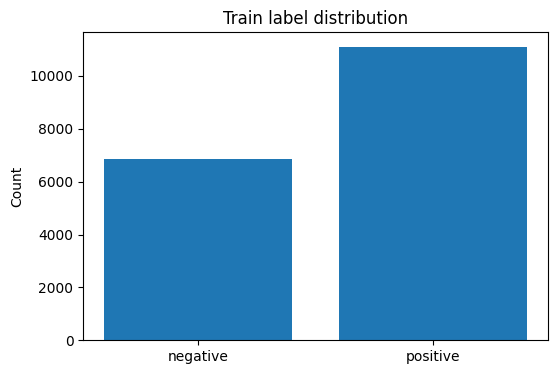

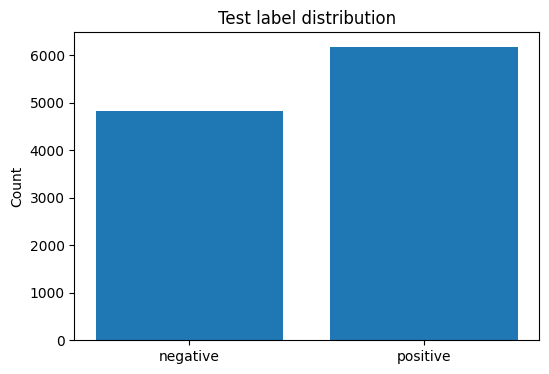

Train label %:
 label
0    0.38164
1    0.61836
Name: proportion, dtype: float64

Test label %:
 label
0    0.43871
1    0.56129
Name: proportion, dtype: float64


In [ ]:
def plot_label_counts(df, title):
    counts = df["label"].value_counts().sort_index()
    labels = [label_map.get(i, str(i)) for i in counts.index]
    
    plt.figure(figsize=(6,4))
    plt.bar(labels, counts.values)
    plt.title(title)
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

plot_label_counts(train_df, "Train label distribution")
plot_label_counts(test_df,  "Test label distribution")

train_counts = train_df["label"].value_counts(normalize=True).sort_index()
test_counts  = test_df["label"].value_counts(normalize=True).sort_index()
print("Train label %:\n", train_counts)
print("\nTest label %:\n", test_counts)


- Statistici despre text
    - distribuția lungimii textelor (caractere + cuvinte) pe clasă
    - outlieri (texte foarte scurte/lungi) -> influențează max_len și padding


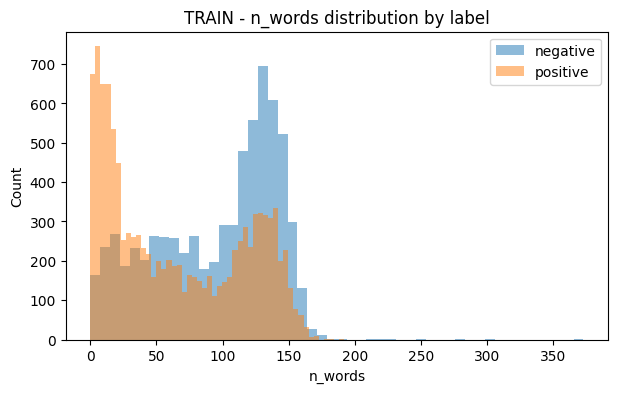

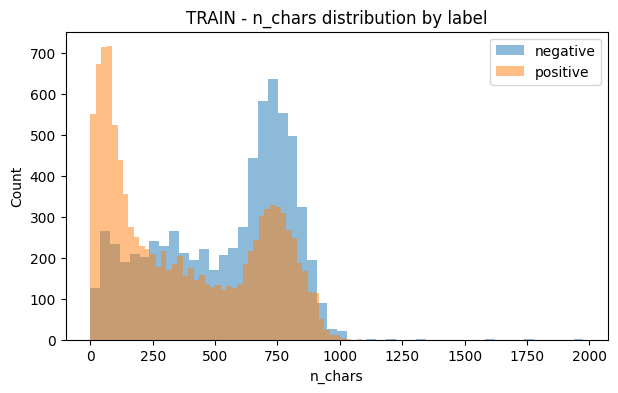


TRAIN n_words percentiles: {50: 77.0, 75: 126.0, 90: 142.0, 95: 148.0, 97: 152.0, 99: 160.0}

TRAIN n_chars percentiles: {50: 436.0, 75: 716.0, 90: 810.0, 95: 855.0, 97: 883.0, 99: 925.0}

Empty texts in train (after fillna): 290


In [ ]:
def add_length_stats(df, text_col="text_filled"):
    s = df[text_col].astype(str)
    out = df.copy()
    out["n_chars"] = s.str.len()
    out["n_words"] = s.str.split().apply(len)
    return out

train_stats = add_length_stats(train_df, "text_filled")
test_stats  = add_length_stats(test_df, "text_filled")

def plot_len_by_label(df, col, title):
    plt.figure(figsize=(7,4))
    for lab in sorted(df["label"].unique()):
        vals = df[df["label"] == lab][col]
        plt.hist(vals, bins=50, alpha=0.5, label=label_map.get(lab, str(lab)))
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend()
    plt.show()

plot_len_by_label(train_stats, "n_words", "TRAIN - n_words distribution by label")
plot_len_by_label(train_stats, "n_chars", "TRAIN - n_chars distribution by label")

for col in ["n_words","n_chars"]:
    ps = [50, 75, 90, 95, 97, 99]
    print(f"\nTRAIN {col} percentiles:", {p: float(np.percentile(train_stats[col], p)) for p in ps})

print("\nEmpty texts in train (after fillna):", (train_stats["n_chars"]==0).sum())



- Vizualizare zgomot

In [7]:
import re

def add_noise_signals(df, text_col="text_filled"):
    s = df[text_col].astype(str)
    out = df.copy()
    out["n_excl"]  = s.str.count("!")
    out["n_q"]     = s.str.count(r"\?")
    out["has_url"] = s.str.contains(r"http[s]?://|www\.", regex=True).astype(int)
    out["has_num"] = s.str.contains(r"\d", regex=True).astype(int)
    out["upper_ratio"] = s.apply(lambda x: sum(ch.isupper() for ch in x)) / s.str.len().clip(lower=1)
    return out

train_sig = add_noise_signals(train_df, "text_filled")

cols = ["n_excl","n_q","has_url","has_num","upper_ratio"]
print(train_sig.groupby("label")[cols].mean().rename(index=label_map).round(4))


          n_excl     n_q  has_url  has_num  upper_ratio
label                                                  
negative  0.6934  0.3702   0.0028   0.4456       0.0001
positive  0.7240  0.1129   0.0039   0.3559       0.0000


/tmp/ipykernel_55/2400762459.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([neg, pos], labels=[label_map[0], label_map[1]])


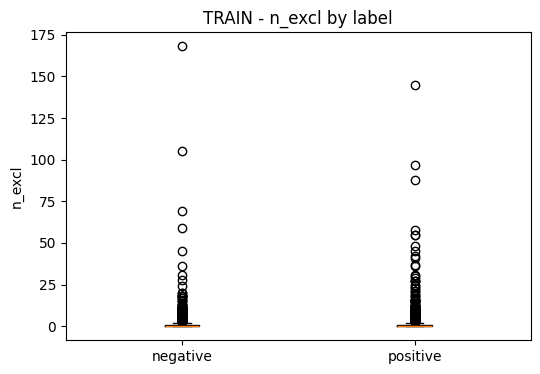

/tmp/ipykernel_55/2400762459.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([neg, pos], labels=[label_map[0], label_map[1]])


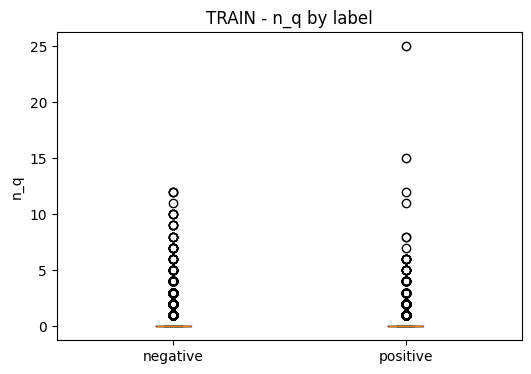

/tmp/ipykernel_55/2400762459.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([neg, pos], labels=[label_map[0], label_map[1]])


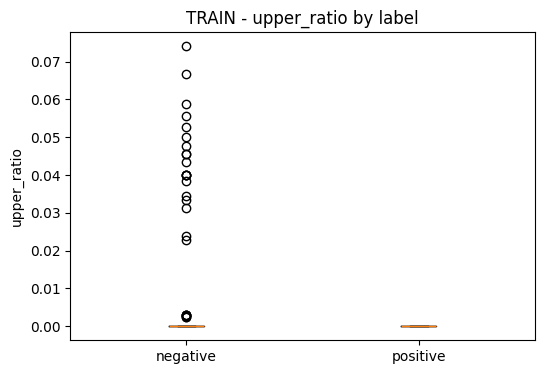

In [ ]:
def boxplot_by_label(df, col, title):
    neg = df[df["label"]==0][col].values
    pos = df[df["label"]==1][col].values
    plt.figure(figsize=(6,4))
    plt.boxplot([neg, pos], labels=[label_map[0], label_map[1]])
    plt.title(title)
    plt.ylabel(col)
    plt.show()

for c in ["n_excl","n_q","upper_ratio"]:
    boxplot_by_label(train_sig, c, f"TRAIN - {c} by label")


In [ ]:
import re

def add_emoticon_signals(df, text_col="text_filled"):
    s = df[text_col].astype(str)
    out = df.copy()
    
    out["has_smiley"] = s.str.contains(r"(:\)|:-\)|=\)|\(\:)", regex=True).astype(int)
    out["has_sad"]    = s.str.contains(r"(:\(|:-\(|=\()", regex=True).astype(int)
    out["has_laugh"]  = s.str.contains(r"(:d|:-d|xd|x-d)", regex=True, case=False).astype(int)
    out["has_heart"]  = s.str.contains(r"(<3)", regex=True).astype(int)
    
    return out

train_emo = add_emoticon_signals(train_df, "text_filled")

cols_emo = ["has_smiley","has_sad","has_laugh","has_heart"]
print(train_emo.groupby("label")[cols_emo].mean().rename(index=label_map).round(4))


/tmp/ipykernel_55/309747386.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  out["has_smiley"] = s.str.contains(r"(:\)|:-\)|=\)|\(\:)", regex=True).astype(int)
/tmp/ipykernel_55/309747386.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  out["has_sad"]    = s.str.contains(r"(:\(|:-\(|=\()", regex=True).astype(int)
/tmp/ipykernel_55/309747386.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  out["has_laugh"]  = s.str.contains(r"(:d|:-d|xd|x-d)", regex=True, case=False).astype(int)


          has_smiley  has_sad  has_laugh  has_heart
label                                              
negative      0.0169   0.0048     0.0022        0.0
positive      0.0403   0.0027     0.0122        0.0


/tmp/ipykernel_55/309747386.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  out["has_heart"]  = s.str.contains(r"(<3)", regex=True).astype(int)


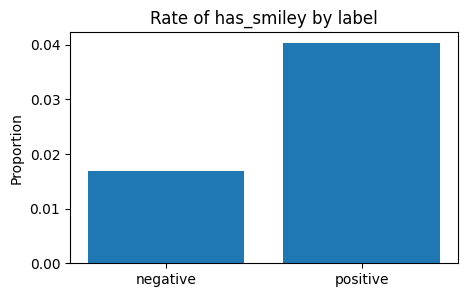

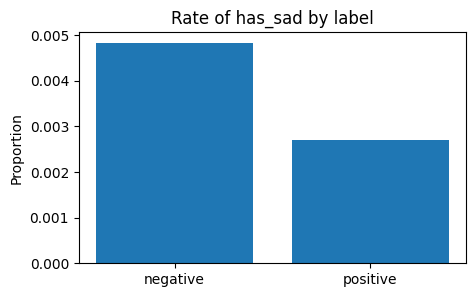

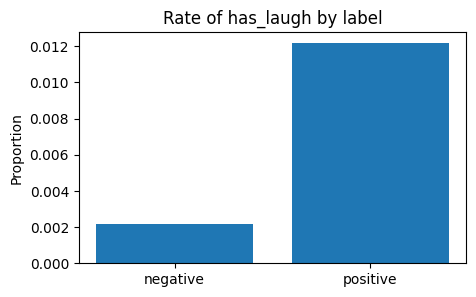

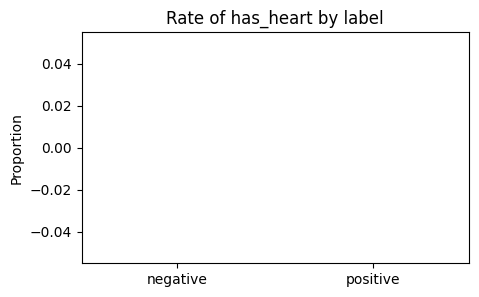

In [10]:
def plot_binary_rate_by_label(df, col):
    rates = df.groupby("label")[col].mean().sort_index()
    labels = [label_map[i] for i in rates.index]
    plt.figure(figsize=(5,3))
    plt.bar(labels, rates.values)
    plt.title(f"Rate of {col} by label")
    plt.ylabel("Proportion")
    plt.show()

for c in cols_emo:
    plot_binary_rate_by_label(train_emo, c)


In [ ]:
for c in cols_emo:
    print(c, "count:", train_emo[c].sum())

display(train_emo[train_emo["has_smiley"]==1][["label","text"]].head(5))


has_smiley count: 563
has_sad count: 63
has_laugh count: 150
has_heart count: 0


,label,text
59,1,excelent\nexact ce imi doream:)
70,1,superb filmul... l`am vazut eiri la cinema acele efecte speciale superb !! merita fiecare banutz asa film mai rar ce...
76,1,anul acesta asteptam cu nerabdare doar 2 filme :\n1.transformers 2\n2.ice age 3\ninsa acum pot spune ca il astept pe...
102,1,foarte buna\nrecomand. imi place si aspectul de auzit de aude ok nu mi de deconecteaza n-am probleme cu ea. multumit...
133,1,unul dintre cele mai bune filme pe care le-am vazut :) as mai plati sa-l vad iar la cinematograf !


-  vizualizarea celor mai frecvente cuvinte per clasa


In [ ]:
from collections import Counter

def eda_tokenize(text: str):
    text = str(text).lower()
    text = re.sub(r"[^0-9a-zăâîșț]+", " ", text)
    return [t for t in text.split() if t]

def top_words_by_label(df, text_col="text_filled", k=30):
    c = {0: Counter(), 1: Counter()}
    for sent, lab in zip(df[text_col].astype(str), df["label"].values):
        c[int(lab)].update(eda_tokenize(sent))

    for lab in [0,1]:
        print(f"\nTop {k} words - {label_map[lab]}:")
        for w, cnt in c[lab].most_common(k):
            print(f"{w:>15s}  {cnt}")

top_words_by_label(train_df, "text_filled", k=40)



Top 40 words - negative:
             de  27321
             si  17234
              a  15267
             nu  13939
             sa  13254
             in  12338
             ca  11934
           este  11709
              o  10856
             un  10691
           film  9033
           care  7766
            mai  7568
             cu  7045
             la  6985
             am  6777
          acest  6571
           fost  6387
         pentru  6235
             pe  6165
            dar  4925
             se  4748
            din  4521
             ce  4156
             fi  3916
             ar  3549
             au  3275
           sunt  3094
             br  2889
           daca  2601
            rau  2493
            sau  2317
         filmul  2316
            lui  2284
         foarte  2207
             va  2159
           asta  2088
           mult  2052
           doar  1995
              l  1951

Top 40 words - positive:
             de  29147
             si  22579
            

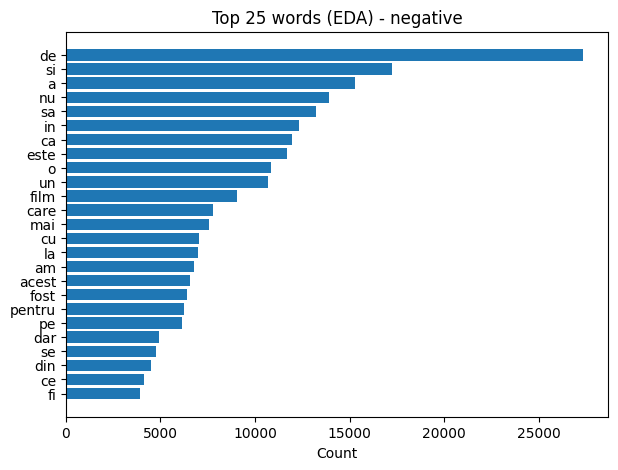

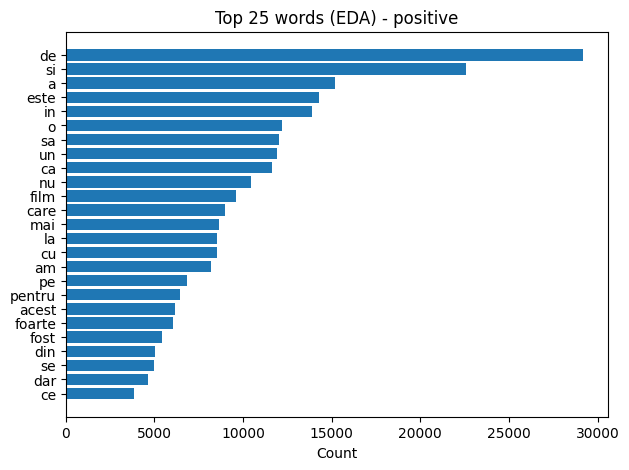

In [13]:
from collections import Counter
import matplotlib.pyplot as plt

def plot_top_words(df, lab, k=20, text_col="text_filled"):
    c = Counter()
    for sent, y in zip(df[text_col].astype(str), df["label"].values):
        if int(y) == lab:
            c.update(eda_tokenize(sent))
    top = c.most_common(k)[::-1]
    words = [w for w,_ in top]
    cnts = [v for _,v in top]

    plt.figure(figsize=(7,5))
    plt.barh(words, cnts)
    plt.title(f"Top {k} words (EDA) - {label_map[lab]}")
    plt.xlabel("Count")
    plt.show()

plot_top_words(train_df, 0, k=25, text_col="text_filled")
plot_top_words(train_df, 1, k=25, text_col="text_filled")


In [ ]:
train_stats = add_length_stats(train_df, text_col="text_filled")

def show_extremes(df, n=5, text_col="text"):
    print("\nShortest by n_words:")
    display(df.sort_values("n_words").head(n)[["label","n_words","n_chars", text_col]])
    print("\nLongest by n_words:")
    display(df.sort_values("n_words", ascending=False).head(n)[["label","n_words","n_chars", text_col]])

show_extremes(train_stats, n=6, text_col="text")

print("---------------------------------")
show_extremes(train_stats, n=6, text_col="text_filled")



Shortest by n_words:


,label,n_words,n_chars,text
14834,0,0,0,NaN
9267,1,0,0,NaN
3262,1,0,0,NaN
10625,1,0,0,NaN
8454,1,0,0,NaN
16909,0,0,0,NaN



Longest by n_words:


,label,n_words,n_chars,text
15887,0,373,1977,djufx88 pe 10 ianuarie 2010 13:40\nslabut\nasta a castigat atia bani si a batut atatea recorduri doar din cauza recl...
11934,0,302,1777,mihaiboghiu pe 19 ianuarie 2010 15:11\nun film foarte plictisitor!!!!\nma asteptam sa vad un film interesant insa fi...
16027,0,279,1596,"costy23zone pe 22 ianuarie 2010 16:49\n""monument de prostie""\neste un film care se incadreaza cu succes in categoria..."
15029,0,253,1124,"aceasta va fi scurta. permiteti-mi mai intai sa afirm ca sunt agnostic si nu prea nebun fata de xtieni, in special f..."
13646,0,231,1334,"julesverne pe 18 ianuarie 2010 21:03\no mare chifla\nmai oameni buni ,in special cei ce dati 1000 de stele fara maca..."
15365,0,222,1322,"bovoro pe 06 ianuarie 2010 23:13\ncum s-or fi traducand in limba na'vi urmatoarele cuvinte: ecologism, fals, exorbit..."


---------------------------------

Shortest by n_words:


,label,n_words,n_chars,text_filled
14834,0,0,0,
9267,1,0,0,
3262,1,0,0,
10625,1,0,0,
8454,1,0,0,
16909,0,0,0,



Longest by n_words:


,label,n_words,n_chars,text_filled
15887,0,373,1977,djufx88 pe 10 ianuarie 2010 13:40\nslabut\nasta a castigat atia bani si a batut atatea recorduri doar din cauza recl...
11934,0,302,1777,mihaiboghiu pe 19 ianuarie 2010 15:11\nun film foarte plictisitor!!!!\nma asteptam sa vad un film interesant insa fi...
16027,0,279,1596,"costy23zone pe 22 ianuarie 2010 16:49\n""monument de prostie""\neste un film care se incadreaza cu succes in categoria..."
15029,0,253,1124,"aceasta va fi scurta. permiteti-mi mai intai sa afirm ca sunt agnostic si nu prea nebun fata de xtieni, in special f..."
13646,0,231,1334,"julesverne pe 18 ianuarie 2010 21:03\no mare chifla\nmai oameni buni ,in special cei ce dati 1000 de stele fara maca..."
15365,0,222,1322,"bovoro pe 06 ianuarie 2010 23:13\ncum s-or fi traducand in limba na'vi urmatoarele cuvinte: ecologism, fals, exorbit..."


In [15]:
missing_by_label = train_df["text"].isna().groupby(train_df["label"]).mean()
print("Missing rate by label:\n", missing_by_label.rename(index=label_map))
print("Missing counts by label:\n", train_df["text"].isna().groupby(train_df["label"]).sum().rename(index=label_map))


Missing rate by label:
 label
negative    0.003067
positive    0.024247
Name: text, dtype: float64
Missing counts by label:
 label
negative     21
positive    269
Name: text, dtype: int64


In [16]:
train_set = set(train_df["text_filled"].astype(str))
test_set  = set(test_df["text_filled"].astype(str))
overlap = len(train_set.intersection(test_set))
print("Exact overlap train-test:", overlap)


Exact overlap train-test: 56


In [17]:
train_set = set(train_df["text_filled"].astype(str))
test_set  = set(test_df["text_filled"].astype(str))

overlap = len(train_set.intersection(test_set))
print("Overlap count:", overlap)
print("Overlap % of unique test:", overlap / len(test_set) * 100)
print("Overlap % of unique train:", overlap / len(train_set) * 100)


Overlap count: 56
Overlap % of unique test: 0.5164622336991607
Overlap % of unique train: 0.3383072554823899


In [18]:
common = train_set.intersection(test_set)
common_df_train = train_df[train_df["text_filled"].isin(common)][["text_filled","label"]].drop_duplicates()
common_df_test  = test_df[test_df["text_filled"].isin(common)][["text_filled","label"]].drop_duplicates()

merged = common_df_train.merge(common_df_test, on="text_filled", how="inner", suffixes=("_train","_test"))
merged["label_match"] = merged["label_train"] == merged["label_test"]

print("Overlaps with matching labels:", merged["label_match"].sum(), "/", len(merged))
display(merged.head(10))


Overlaps with matching labels: 56 / 56


,text_filled,label_train,label_test,label_match
0,"nu sunt in masura sa ii acord o nota, pentru ca nu sunt un critic, ci doar categorisesc filmele si serialele pe care...",1,1,True
1,mi se pare un film foarte bun care merita vazut la fel ca si celelalte filme din seria pirates of the caribbean . sp...,1,1,True
2,"filmul a fost excelent, cu exceptia catorva scene cu esposito. m-am bucurat cum a reunit fiecare detectiv al serialu...",1,1,True
3,"sunt un fan imens m lillard, de aceea am ajuns sa ma uit la acest film. sincer, ma indoiesc ca, daca nu era in film,...",1,1,True
4,"dupa toti acesti ani, a lui peter o'tool, dansul sclipitor si costisitor al sufletului sau, filmul dupa film, hollyw...",1,1,True
5,"inainte de a viziona acest film de televiziune, nu stiam prea multe despre una dintre actritele mele preferate. dupa...",1,1,True
6,ce pot sa spun? un sfarsit excelent pentru o serie excelenta! nu a obtinut niciodata expunerea pe care o merita in a...,1,1,True
7,"hlots a fost o serie remarcabila, ceea ce nypd blue nu va mai fi niciodata, pe hlots parcelele sunt reale, dialogul ...",1,1,True
8,"am fost intotdeauna un fan al spectacolului, asa ca recunosc ca sunt partinitoare. cand sa terminat spectacolul, am ...",1,1,True
9,seria mea de politie preferata din toate timpurile se transforma intr-un film tv. functioneaza? da. gee ruleaza pent...,1,1,True


In [19]:
display(merged.sample(min(5, len(merged)), random_state=42)[["label_train","label_test","text_filled"]])


,label_train,label_test,text_filled
0,1,1,"nu sunt in masura sa ii acord o nota, pentru ca nu sunt un critic, ci doar categorisesc filmele si serialele pe care..."
5,1,1,"inainte de a viziona acest film de televiziune, nu stiam prea multe despre una dintre actritele mele preferate. dupa..."
33,0,0,"o adaptare absolut atroceasca a cartii minunate a copiilor. umorul brutal si neadecvat, unele parti infricosatoare s..."
13,1,1,love it! ;)
19,0,0,inspiratia medievala si in josul corectiei degradanta a povestii clasice a copiilor nu numai ca nu are farmecul stra...


In [20]:
display(train_stats.groupby("label")[["n_words","n_chars"]].describe().rename(index=label_map))


n_words                                                        \
            count       mean        std  min   25%    50%    75%    max   
label                                                                     
negative   6847.0  95.380166  45.909562  0.0  57.0  110.0  133.0  373.0   
positive  11094.0  64.953669  51.184470  0.0  16.0   53.0  117.0  192.0   

          n_chars                                                             
            count        mean         std  min    25%    50%     75%     max  
label                                                                         
negative   6847.0  540.305097  261.992725  0.0  319.0  627.0  752.00  1977.0  
positive  11094.0  374.990175  295.007764  0.0   92.0  305.0  676.75  1090.0

## 2. Tokenizare + Embedding Layer

Pași:
1) Curățare / normalizare text (caractere speciale, spații, diacritice, etc.)
2) Tokenizare spaCy -> secvențe de token-uri
3) Construire vocab + tratare OOV (cuvinte necunoscute)
4) Padding la lungime fixă
5) Embedding: fastText pre-antrenat => matrice de embedding + Embedding layer


In [ ]:
import os
import re
import unicodedata

import numpy as np
import pandas as pd
from collections import Counter

train_df = pd.read_csv(TRAIN_URL)
test_df  = pd.read_csv(TEST_URL)

train_df = train_df.drop(columns=["index"], errors="ignore")
test_df  = test_df.drop(columns=["Unnamed: 0"], errors="ignore")

train_df["text"] = train_df["text"].astype("string")
test_df["text"]  = test_df["text"].astype("string")

n_missing = train_df["text"].isna().sum()
print("Missing text in train:", n_missing)

train_df = train_df.dropna(subset=["text"]).copy()
train_df = train_df[train_df["text"].str.strip().str.len() > 0].copy()

test_df = test_df.dropna(subset=["text"]).copy()
test_df = test_df[test_df["text"].str.strip().str.len() > 0].copy()

print("Train shape after dropping empty:", train_df.shape)
print("Test  shape after dropping empty:", test_df.shape)


Missing text in train: 290
Train shape after dropping empty: (17651, 2)
Test  shape after dropping empty: (11005, 2)


1. Curatare si normalizare text

In [ ]:
URL_RE = re.compile(r"(http[s]?://\S+|www\.\S+)", re.IGNORECASE)
MULTISPACE_RE = re.compile(r"\s+")
KEEP_RE = re.compile(r"[^0-9a-zăâîșț \.\,\!\?\:\;\-\(\)\"\'\/]", re.IGNORECASE)

def normalize_romanian(text: str) -> str:
    text = str(text)

    text = unicodedata.normalize("NFKC", text)

    text = text.replace("ş", "ș").replace("Ş", "Ș").replace("ţ", "ț").replace("Ţ", "Ț")

    text = text.lower()

    text = URL_RE.sub(" <URL> ", text)

    text = KEEP_RE.sub(" ", text)

    text = MULTISPACE_RE.sub(" ", text).strip()
    return text

train_df["text_clean"] = train_df["text"].apply(normalize_romanian)
test_df["text_clean"]  = test_df["text"].apply(normalize_romanian)

train_df[["text","text_clean","label"]].head(3)


,text,text_clean,label
0,acest document mi-a deschis cu adevarat ochii la ceea ce oamenii din afara statelor unite s-au gandit la atacurile d...,acest document mi-a deschis cu adevarat ochii la ceea ce oamenii din afara statelor unite s-au gandit la atacurile d...,1
1,"tine mancarea rece. ce altceva ii mai trebuie? am frigiderul de vreun an, utilizare continua. zgomotul e decent spre...","tine mancarea rece. ce altceva ii mai trebuie? am frigiderul de vreun an, utilizare continua. zgomotul e decent spre...",1
2,excelent recomand!,excelent recomand!,1


2. Tokenizare spaCy

In [ ]:

!pip -q install spacy
!python -m spacy download ro_core_news_sm


import spacy

def load_spacy_ro():
    try:
        return spacy.load("ro_core_news_sm", disable=["tagger","parser","ner","lemmatizer"])
    except Exception:
        try:
            return spacy.load("ro_core_news_sm", disable=["tagger","parser","ner","lemmatizer"])
        except Exception:
            print("warning")
            return spacy.blank("ro")

nlp = load_spacy_ro()

def spacy_tokenize(text: str):
    doc = nlp(text)
    toks = []
    for t in doc:
        if t.is_space:
            continue
        tok = t.text
        if tok == "<URL>":
            toks.append(tok)
        else:
            tok2 = re.sub(r"[^0-9a-zăâîșț]+", "", tok)
            if tok2:
                toks.append(tok2)
    return toks

for i in range(3):
    print(train_df["text_clean"].iloc[i])
    print(spacy_tokenize(train_df["text_clean"].iloc[i])[:25])
    print("---")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 105.6 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('ro_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
acest document mi-a deschis cu adevarat ochii la ceea ce oamenii din afara statelor unite s-au gandit la atacurile din 11 septembrie. acest film a fost construit in mod expert si prezinta acest dezastru ca fiind mai mult decat un atac asupra pamantului american. urmarile acestui dezastru sunt previzionate din multe tari si perspective diferite. cred ca acest film ar trebui sa fie mai bine distribuit pentru acest punct. de asemenea, el ajuta in procesul de vindecare sa vada in cele din urma altceva decat stirile despre atacurile teroriste. si unele dintre piese sunt d

3. Eliminare stop words

In [ ]:
from spacy.lang.ro.stop_words import STOP_WORDS as RO_STOP

USE_STOPWORDS = False

def tokenize(text: str):
    toks = spacy_tokenize(text)
    if USE_STOPWORDS:
        toks = [t for t in toks if t not in RO_STOP]
    return toks

print(tokenize(train_df["text_clean"].iloc[0])[:30])


['acest', 'document', 'mi', 'a', 'deschis', 'cu', 'adevarat', 'ochii', 'la', 'ceea', 'ce', 'oamenii', 'din', 'afara', 'statelor', 'unite', 's', 'au', 'gandit', 'la', 'atacurile', 'din', '11', 'septembrie', 'acest', 'film', 'a', 'fost', 'construit', 'in']


4. Construire vocabular + OOV

In [ ]:
train_tokens = [tokenize(t) for t in train_df["text_clean"].tolist()]

freq = Counter()
for toks in train_tokens:
    freq.update(toks)

MAX_VOCAB = 50000
MIN_FREQ = 2

specials = ["<PAD>", "<UNK>", "<URL>"]
word_list = [w for w,c in freq.most_common() if c >= MIN_FREQ and w not in specials]
word_list = word_list[: max(0, MAX_VOCAB - len(specials))]

itos = specials + word_list
stoi = {w:i for i,w in enumerate(itos)}

PAD_IDX = stoi["<PAD>"]
UNK_IDX = stoi["<UNK>"]

print("Vocab size:", len(itos))
print("Example mapping:", list(stoi.items())[:10])
print("UNK idx:", UNK_IDX, "PAD idx:", PAD_IDX)

def encode_tokens(toks):
    return [stoi.get(t, UNK_IDX) for t in toks]


Vocab size: 28882
Example mapping: [('<PAD>', 0), ('<UNK>', 1), ('<URL>', 2), ('de', 3), ('si', 4), ('a', 5), ('in', 6), ('este', 7), ('sa', 8), ('nu', 9)]
UNK idx: 1 PAD idx: 0


5. Transformare texte in secvente de indici

In [ ]:
train_seqs = [encode_tokens(toks) for toks in train_tokens]
test_tokens = [tokenize(t) for t in test_df["text_clean"].tolist()]
test_seqs  = [encode_tokens(toks) for toks in test_tokens]

print(train_seqs[0][:30])
print("len:", len(train_seqs[0]))


[20, 5107, 43, 5, 1498, 16, 105, 695, 17, 91, 27, 214, 25, 317, 9276, 3128, 127, 30, 411, 17, 8561, 25, 1259, 2802, 20, 13, 5, 22, 3776, 6]
len: 118


6. Padding pe lungime fixa

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence

MAX_LEN = 160

def pad_to_maxlen(seq, max_len=MAX_LEN, pad_value=PAD_IDX):
    if len(seq) >= max_len:
        return seq[:max_len]
    return seq + [pad_value] * (max_len - len(seq))

train_padded = torch.tensor([pad_to_maxlen(s) for s in train_seqs], dtype=torch.long)
test_padded  = torch.tensor([pad_to_maxlen(s) for s in test_seqs], dtype=torch.long)

y_train = torch.tensor(train_df["label"].values, dtype=torch.long)
y_test  = torch.tensor(test_df["label"].values, dtype=torch.long)

print("train_padded shape:", train_padded.shape)
print("test_padded shape:", test_padded.shape)


train_padded shape: torch.Size([17651, 160])
test_padded shape: torch.Size([11005, 160])


7. Download fastText RO

In [ ]:
VEC_GZ_URL = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ro.300.vec.gz"
VEC_GZ_PATH = "/kaggle/working/cc.ro.300.vec.gz"
VEC_PATH = "/kaggle/working/cc.ro.300.vec"

if not os.path.exists(VEC_PATH):
    if not os.path.exists(VEC_GZ_PATH):
        print("Downloading fastText vectors")
        !wget -q -O "{VEC_GZ_PATH}" "{VEC_GZ_URL}"
    print("Unzipping...")
    !gunzip -c "{VEC_GZ_PATH}" > "{VEC_PATH}"

print("Vector file exists:", os.path.exists(VEC_PATH), "size:", os.path.getsize(VEC_PATH) if os.path.exists(VEC_PATH) else None)


Unzipping...
Vector file exists: True size: 4525404651


8. Constructie embedding matrix

In [ ]:
EMB_DIM = 300
embedding_matrix = np.random.normal(0, 0.05, size=(len(itos), EMB_DIM)).astype(np.float32)
embedding_matrix[PAD_IDX] = np.zeros(EMB_DIM, dtype=np.float32)

found = 0
needed = set(stoi.keys())

with open(VEC_PATH, "r", encoding="utf-8", errors="ignore") as f:
    header = f.readline()
    for line in f:
        parts = line.rstrip().split(" ")
        if len(parts) <= EMB_DIM:
            continue
        word = parts[0]
        if word in stoi:
            vec = np.array(parts[1:1+EMB_DIM], dtype=np.float32)
            embedding_matrix[stoi[word]] = vec
            found += 1

print(f"Found {found} vectors for vocab of size {len(itos)} (coverage={(found/len(itos))*100:.2f}%)")


Found 25403 vectors for vocab of size 28882 (coverage=87.95%)


9. Embedding layer

In [ ]:
import torch.nn as nn

embedding_layer = nn.Embedding.from_pretrained(
    embeddings=torch.tensor(embedding_matrix),
    freeze=False,
    padding_idx=PAD_IDX
)

x = train_padded[:4]
emb = embedding_layer(x)
print("Input shape:", x.shape)
print("Embedded shape:", emb.shape)


Input shape: torch.Size([4, 160])
Embedded shape: torch.Size([4, 160, 300])


## 3. RNN Simplu

In [31]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:

X = train_padded
y = y_train

idx = np.arange(len(y))
train_idx, val_idx = train_test_split(
    idx, test_size=0.15, random_state=SEED, stratify=y.cpu().numpy()
)

class TextDataset(Dataset):
    def __init__(self, X, y, indices):
        self.X = X[indices]
        self.y = y[indices]
    def __len__(self):
        return len(self.y)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

BATCH_SIZE = 128

train_ds = TextDataset(X, y, train_idx)
val_ds   = TextDataset(X, y, val_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

train_loader_base = train_loader
val_loader_base = val_loader
print("Train batches:", len(train_loader), "Val batches:", len(val_loader))


Train batches: 118 Val batches: 21


In [ ]:
def get_lengths(batch_x, pad_idx=PAD_IDX):
    lengths = (batch_x != pad_idx).sum(dim=1).cpu()
    lengths = torch.clamp(lengths, min=1)
    return lengths

@torch.no_grad()
def evaluate_model(model, loader):
    model.eval()
    all_preds, all_true = [], []
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        lengths = get_lengths(xb, PAD_IDX).to(device)

        logits = model(xb, lengths)
        loss = model.loss_fn(logits, yb)
        total_loss += loss.item() * xb.size(0)

        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_true.append(yb.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_true  = np.concatenate(all_true)

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_true, all_preds)
    f1  = f1_score(all_true, all_preds)
    return avg_loss, acc, f1


In [ ]:
class SimpleRNNClassifier(nn.Module):
    def __init__(self, embedding_matrix, pad_idx, hidden_size=128, num_layers=1, dropout=0.2):
        super().__init__()
        vocab_size, emb_dim = embedding_matrix.shape

        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
        self.embedding.weight.requires_grad = True

        self.rnn = nn.RNN(
            input_size=emb_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=(dropout if num_layers > 1 else 0.0),
            nonlinearity="tanh"
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 2)

        self.loss_fn = None

    def forward(self, x, lengths):
        emb = self.embedding(x)

        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out, h_n = self.rnn(packed)  
        last = h_n[-1]

        last = self.dropout(last)
        logits = self.fc(last)
        return logits


In [ ]:
def train_one_epoch(model, loader, optimizer, clip=1.0):
    model.train()
    total_loss = 0.0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        lengths = get_lengths(xb, PAD_IDX).to(device)

        optimizer.zero_grad()
        logits = model(xb, lengths)
        loss = model.loss_fn(logits, yb)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        total_loss += loss.item() * xb.size(0)

    return total_loss / len(loader.dataset)

def fit_rnn(config, max_epochs=8, lr=1e-3, weight_decay=0.0, patience=2, clip=1.0, verbose=True):
    y_np = y_train.cpu().numpy()
    neg = (y_np == 0).sum()
    pos = (y_np == 1).sum()
    w0 = (neg + pos) / (2.0 * neg)
    w1 = (neg + pos) / (2.0 * pos)
    class_weights = torch.tensor([w0, w1], dtype=torch.float32, device=device)

    model = SimpleRNNClassifier(
        embedding_matrix=embedding_matrix,
        pad_idx=PAD_IDX,
        hidden_size=config["hidden_size"],
        num_layers=config["num_layers"],
        dropout=config["dropout"]
    ).to(device)

    model.loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {"train_loss": [], "val_loss": [], "val_acc": [], "val_f1": []}

    best_f1 = -1.0
    best_state = None
    best_epoch = None
    best_val_loss = None
    best_val_acc = None
    bad_epochs = 0
    stop_reason = "max_epochs_reached"

    for epoch in range(1, max_epochs + 1):
        tr_loss = train_one_epoch(model, train_loader, optimizer, clip=clip)
        va_loss, va_acc, va_f1 = evaluate_model(model, val_loader)

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)
        history["val_f1"].append(va_f1)

        if verbose:
            print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | val_acc={va_acc:.4f} | val_f1={va_f1:.4f}")

        improved = va_f1 > best_f1 + 1e-4
        if improved:
            best_f1 = va_f1
            best_epoch = epoch
            best_val_loss = va_loss
            best_val_acc = va_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                stop_reason = f"early_stopping(patience={patience})"
                if verbose:
                    print(f"Early stopping at epoch {epoch} (no val_f1 improvement for {bad_epochs} consecutive epochs).")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    summary = {
        "config": config,
        "stop_reason": stop_reason,
        "epochs_ran": len(history["train_loss"]),
        "best_epoch": best_epoch,
        "best_val_f1": float(best_f1),
        "best_val_acc": float(best_val_acc) if best_val_acc is not None else None,
        "best_val_loss": float(best_val_loss) if best_val_loss is not None else None,
        "patience": patience,
    }

    print("\nSummary:")
    print("Config:", config)
    print("Stop reason:", summary["stop_reason"])
    print("Epochs ran:", summary["epochs_ran"])
    print(f"Best epoch {summary['best_epoch']}: val_f1={summary['best_val_f1']:.4f}, val_acc={summary['best_val_acc']:.4f}, val_loss={summary['best_val_loss']:.4f}")
    print("\n")

    return model, history, best_f1, summary



In [ ]:
MAX_EPOCHS = 30
PATIENCE = 6

configs = [
    {"name":"rnn_h128_l1_d0.2", "hidden_size":128, "num_layers":1, "dropout":0.2},
    {"name":"rnn_h256_l1_d0.2", "hidden_size":256, "num_layers":1, "dropout":0.2},
    {"name":"rnn_h128_l2_d0.3", "hidden_size":128, "num_layers":2, "dropout":0.3},
    {"name":"rnn_h256_l2_d0.3", "hidden_size":256, "num_layers":2, "dropout":0.3},
    {"name":"rnn_h128_l1_d0.4", "hidden_size":128, "num_layers":1, "dropout":0.4},
    {"name":"rnn_h256_l1_d0.4", "hidden_size":256, "num_layers":1, "dropout":0.4},
]

results = []
models = {}
summaries = {}
histories = {}

for cfg in configs:
    print("\n====", cfg["name"], "====")
    model, hist, best_f1, summary = fit_rnn(
        cfg,
        max_epochs=MAX_EPOCHS,
        lr=1e-3,
        weight_decay=1e-4,
        patience=PATIENCE,
        clip=1.0
    )
    results.append((cfg["name"], best_f1))
    models[cfg["name"]] = model
    summaries[cfg["name"]] = summary
    histories[cfg["name"]] = hist

results_sorted = sorted(results, key=lambda x: x[1], reverse=True)

print("\nRNN results (sorted by best val F1):")
for name, f1 in results_sorted:
    print(f"{name:20s} best_val_f1={f1:.4f}")

import pandas as pd
summary_df = pd.DataFrame([
    {
        "name": name,
        "hidden": summaries[name]["config"]["hidden_size"],
        "layers": summaries[name]["config"]["num_layers"],
        "dropout": summaries[name]["config"]["dropout"],
        "epochs_ran": summaries[name]["epochs_ran"],
        "best_epoch": summaries[name]["best_epoch"],
        "best_val_f1": summaries[name]["best_val_f1"],
        "best_val_acc": summaries[name]["best_val_acc"],
        "best_val_loss": summaries[name]["best_val_loss"],
        "stop_reason": summaries[name]["stop_reason"],
    }
    for name in summaries
]).sort_values("best_val_f1", ascending=False)

summary_df



==== rnn_h128_l1_d0.2 ====
Epoch 01 | train_loss=0.5440 | val_loss=0.4625 | val_acc=0.8202 | val_f1=0.8641
Epoch 02 | train_loss=0.3089 | val_loss=0.3788 | val_acc=0.8531 | val_f1=0.8802
Epoch 03 | train_loss=0.2102 | val_loss=0.4515 | val_acc=0.8516 | val_f1=0.8810
Epoch 04 | train_loss=0.1304 | val_loss=0.4776 | val_acc=0.8100 | val_f1=0.8395
Epoch 05 | train_loss=0.0842 | val_loss=0.5597 | val_acc=0.8184 | val_f1=0.8479
Epoch 06 | train_loss=0.0580 | val_loss=0.7403 | val_acc=0.8180 | val_f1=0.8574
Epoch 07 | train_loss=0.0398 | val_loss=0.7581 | val_acc=0.8372 | val_f1=0.8653
Epoch 08 | train_loss=0.0347 | val_loss=0.7910 | val_acc=0.8134 | val_f1=0.8469
Epoch 09 | train_loss=0.0201 | val_loss=1.1446 | val_acc=0.8270 | val_f1=0.8666
Early stopping at epoch 9 (no val_f1 improvement for 6 consecutive epochs).

Summary:
Config: {'name': 'rnn_h128_l1_d0.2', 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.2}
Stop reason: early_stopping(patience=6)
Epochs ran: 9
Best epoch 3: val_f1=0

,name,hidden,layers,dropout,epochs_ran,best_epoch,best_val_f1,best_val_acc,best_val_loss,stop_reason
3,rnn_h256_l2_d0.3,256,2,0.3,8,2,0.884105,0.851586,0.410158,early_stopping(patience=6)
0,rnn_h128_l1_d0.2,128,1,0.2,9,3,0.881017,0.851586,0.451504,early_stopping(patience=6)
5,rnn_h256_l1_d0.4,256,1,0.4,11,5,0.875696,0.848187,0.542840,early_stopping(patience=6)
4,rnn_h128_l1_d0.4,128,1,0.4,8,2,0.874031,0.852719,0.361146,early_stopping(patience=6)
1,rnn_h256_l1_d0.2,256,1,0.2,12,6,0.867536,0.834970,0.719376,early_stopping(patience=6)
2,rnn_h128_l2_d0.3,128,2,0.3,11,5,0.866686,0.825151,0.795195,early_stopping(patience=6)


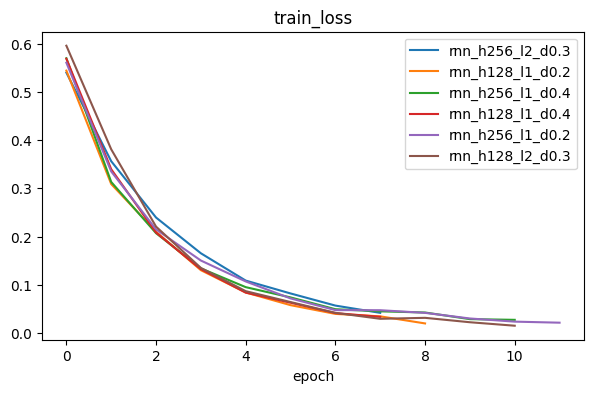

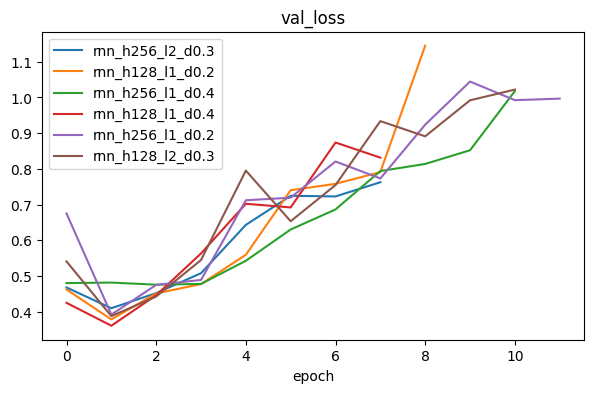

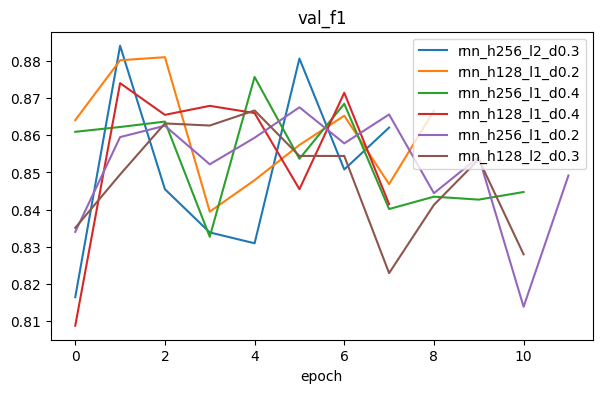

In [37]:
def plot_histories(results_sorted, histories, metric="val_f1", top_k=None):
    plt.figure(figsize=(7,4))
    items = results_sorted if top_k is None else results_sorted[:top_k]
    for name, _ in items:
        plt.plot(histories[name][metric], label=name)
    plt.title(metric)
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

plot_histories(results_sorted, histories, metric="train_loss", top_k=6)
plot_histories(results_sorted, histories, metric="val_loss", top_k=6)
plot_histories(results_sorted, histories, metric="val_f1", top_k=6)


Alegem cea mai buna configuratie pentru etapa de test

In [ ]:
best_name = "rnn_h128_l2_d0.3"
best_model = models[best_name]

test_ds = TextDataset(test_padded, y_test, np.arange(len(y_test)))
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

test_loss, test_acc, test_f1 = evaluate_model(best_model, test_loader)
print("BEST (no augmentation):", best_name)
print(f"TEST | loss={test_loss:.4f} | acc={test_acc:.4f} | f1={test_f1:.4f}")


BEST (no augmentation): rnn_h128_l2_d0.3
TEST | loss=0.7912 | acc=0.7886 | f1=0.8256


F1 (binary): 0.8256
F1 (macro):  0.7785
              precision    recall  f1-score   support

    negative       0.83      0.66      0.73      4828
    positive       0.77      0.89      0.83      6177

    accuracy                           0.79     11005
   macro avg       0.80      0.77      0.78     11005
weighted avg       0.79      0.79      0.78     11005



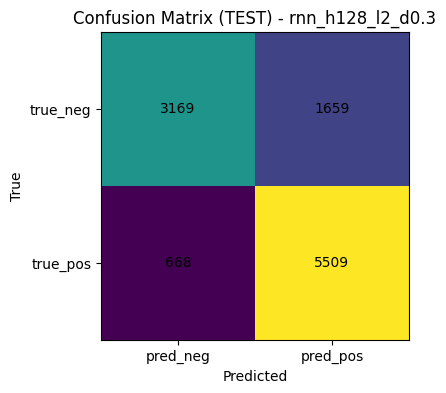

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np
import matplotlib.pyplot as plt

best_model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        lengths = get_lengths(xb, PAD_IDX).to(device)
        logits = best_model(xb, lengths)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_true.append(yb.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_true  = np.concatenate(all_true)

print("F1 (binary):", round(f1_score(all_true, all_preds), 4))
print("F1 (macro): ", round(f1_score(all_true, all_preds, average="macro"), 4))
print(classification_report(all_true, all_preds, target_names=["negative","positive"]))

cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(4,4))
plt.imshow(cm)
plt.title(f"Confusion Matrix (TEST) - {best_name}")
plt.xticks([0,1], ["pred_neg","pred_pos"])
plt.yticks([0,1], ["true_neg","true_pos"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Pentru cea mai buna configuratie, vom incerca sa reantrenam, dar de data asta si cu augmentare

In [ ]:
best_rnn_cfg = {"name":"rnn_h128_l2_d0.3", "hidden_size":128, "num_layers":2, "dropout":0.3}

# # set seed pentru comparație mai stabilă
# import random, numpy as np, torch
# SEED = 42
# random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# # Baseline no-augmentation
# model_noaug, hist_noaug, best_f1_noaug, summary_noaug = fit_rnn(
#     best_cfg,
#     max_epochs=30,
#     lr=1e-3,
#     weight_decay=1e-4,
#     patience=6,
#     clip=1.0
# )
# print("Best val F1 (no-aug):", best_f1_noaug)

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

train_loader = train_loader_base
val_loader = val_loader_base

rnn_noaug, hist_rnn_noaug, best_f1_rnn_noaug, summ_rnn_noaug = fit_rnn(
    best_rnn_cfg,
    max_epochs=30,
    lr=1e-3,
    weight_decay=1e-4,
    patience=6,
    clip=1.0
)

print("Best val F1 (RNN no-aug):", best_f1_rnn_noaug)



Epoch 01 | train_loss=0.5667 | val_loss=0.4023 | val_acc=0.8161 | val_f1=0.8373
Epoch 02 | train_loss=0.3427 | val_loss=0.5177 | val_acc=0.8421 | val_f1=0.8806
Epoch 03 | train_loss=0.2282 | val_loss=0.4112 | val_acc=0.8606 | val_f1=0.8868
Epoch 04 | train_loss=0.1422 | val_loss=0.4784 | val_acc=0.8546 | val_f1=0.8800
Epoch 05 | train_loss=0.0813 | val_loss=0.6332 | val_acc=0.8437 | val_f1=0.8686
Epoch 06 | train_loss=0.0542 | val_loss=0.8386 | val_acc=0.8327 | val_f1=0.8701
Epoch 07 | train_loss=0.0525 | val_loss=0.7780 | val_acc=0.8255 | val_f1=0.8557
Epoch 08 | train_loss=0.0379 | val_loss=0.8665 | val_acc=0.8210 | val_f1=0.8585
Epoch 09 | train_loss=0.0361 | val_loss=0.7766 | val_acc=0.8119 | val_f1=0.8426
Early stopping at epoch 9 (no val_f1 improvement for 6 consecutive epochs).

Summary:
Config: {'name': 'rnn_h128_l2_d0.3', 'hidden_size': 128, 'num_layers': 2, 'dropout': 0.3}
Stop reason: early_stopping(patience=6)
Epochs ran: 9
Best epoch 3: val_f1=0.8868, val_acc=0.8606, val_l

In [41]:
import random

def random_delete(tokens, p=0.1):
    if len(tokens) <= 2:
        return tokens
    out = [t for t in tokens if random.random() > p]
    return out if len(out) > 0 else tokens

def random_swap(tokens, n_swaps=1):
    tokens = tokens.copy()
    if len(tokens) < 2:
        return tokens
    for _ in range(n_swaps):
        i, j = random.sample(range(len(tokens)), 2)
        tokens[i], tokens[j] = tokens[j], tokens[i]
    return tokens

def random_insert(tokens, vocab_list, n_inserts=1):
    tokens = tokens.copy()
    if len(tokens) == 0:
        return tokens
    for _ in range(n_inserts):
        idx = random.randrange(len(tokens) + 1)
        tokens.insert(idx, random.choice(vocab_list))
    return tokens

def augment_tokens(tokens, vocab_list, p_delete=0.1, n_swaps=1, n_inserts=1):
    op = random.choice(["del", "swap", "ins"])
    if op == "del":
        return random_delete(tokens, p=p_delete)
    if op == "swap":
        return random_swap(tokens, n_swaps=n_swaps)
    return random_insert(tokens, vocab_list=vocab_list, n_inserts=n_inserts)


In [ ]:
AUGMENT_FRACTION = 0.3
P_DELETE = 0.1
N_SWAPS = 1
N_INSERTS = 1

vocab_for_insert = [w for w in itos if w not in ["<PAD>","<UNK>","<URL>"]]
vocab_for_insert = vocab_for_insert[:20000]

random.seed(SEED)

train_idx_list = list(train_idx)
n_aug = int(len(train_idx_list) * AUGMENT_FRACTION)
aug_indices = random.sample(train_idx_list, n_aug)

base_train_seqs = [train_seqs[i] for i in train_idx_list]
base_train_labels = [int(y_train[i].item()) for i in train_idx_list]

aug_seqs = []
aug_labels = []

for i in aug_indices:
    toks = train_tokens[i]
    toks_aug = augment_tokens(toks, vocab_for_insert, p_delete=P_DELETE, n_swaps=N_SWAPS, n_inserts=N_INSERTS)
    seq_aug = encode_tokens(toks_aug)
    aug_seqs.append(seq_aug)
    aug_labels.append(int(y_train[i].item()))

train_seqs_augmented = base_train_seqs + aug_seqs
train_labels_augmented = base_train_labels + aug_labels

print("Train split original:", len(base_train_seqs))
print("Added augmented samples:", len(aug_seqs))
print("Train split total (aug):", len(train_seqs_augmented))


Train split original: 15003
Added augmented samples: 4500
Train split total (aug): 19503


In [43]:
import torch
from torch.utils.data import DataLoader

train_padded_aug = torch.tensor([pad_to_maxlen(s) for s in train_seqs_augmented], dtype=torch.long)
y_train_aug = torch.tensor(train_labels_augmented, dtype=torch.long)

aug_train_ds = TextDataset(train_padded_aug, y_train_aug, np.arange(len(y_train_aug)))
train_loader_aug = DataLoader(aug_train_ds, batch_size=128, shuffle=True, drop_last=False)

print("train_padded_aug shape:", train_padded_aug.shape)


train_padded_aug shape: torch.Size([19503, 160])


In [44]:
print("Have train_loader_aug?", "train_loader_aug" in globals())

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

train_loader = train_loader_base
val_loader = val_loader_base

orig_train_loader = train_loader

try:
    train_loader = train_loader_aug
    rnn_aug, hist_rnn_aug, best_f1_rnn_aug, summ_rnn_aug = fit_rnn(
        best_rnn_cfg,
        max_epochs=30,
        lr=1e-3,
        weight_decay=1e-4,
        patience=6,
        clip=1.0
    )
finally:
    train_loader = orig_train_loader

print("Best val F1 (RNN with-aug):", best_f1_rnn_aug)


Have train_loader_aug? True
Epoch 01 | train_loss=0.5172 | val_loss=0.4041 | val_acc=0.8501 | val_f1=0.8764
Epoch 02 | train_loss=0.2729 | val_loss=0.3916 | val_acc=0.8414 | val_f1=0.8658
Epoch 03 | train_loss=0.1584 | val_loss=0.5116 | val_acc=0.8429 | val_f1=0.8772
Epoch 04 | train_loss=0.1234 | val_loss=0.5833 | val_acc=0.8225 | val_f1=0.8534
Epoch 05 | train_loss=0.0762 | val_loss=0.6756 | val_acc=0.8319 | val_f1=0.8600
Epoch 06 | train_loss=0.0464 | val_loss=0.7313 | val_acc=0.7968 | val_f1=0.8260
Epoch 07 | train_loss=0.0392 | val_loss=0.7921 | val_acc=0.8157 | val_f1=0.8435
Epoch 08 | train_loss=0.0338 | val_loss=0.9348 | val_acc=0.8323 | val_f1=0.8618
Epoch 09 | train_loss=0.0169 | val_loss=1.1173 | val_acc=0.8323 | val_f1=0.8675
Early stopping at epoch 9 (no val_f1 improvement for 6 consecutive epochs).

Summary:
Config: {'name': 'rnn_h128_l2_d0.3', 'hidden_size': 128, 'num_layers': 2, 'dropout': 0.3}
Stop reason: early_stopping(patience=6)
Epochs ran: 9
Best epoch 3: val_f1=0

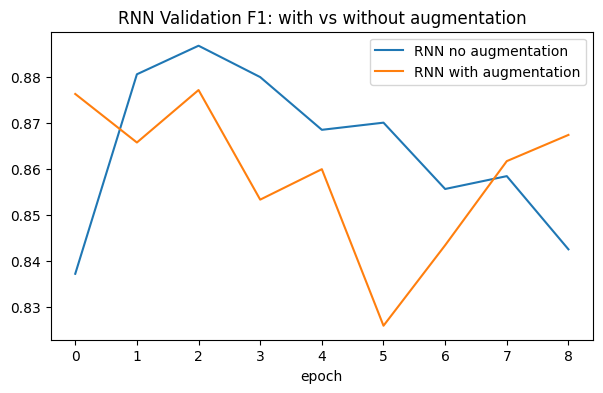

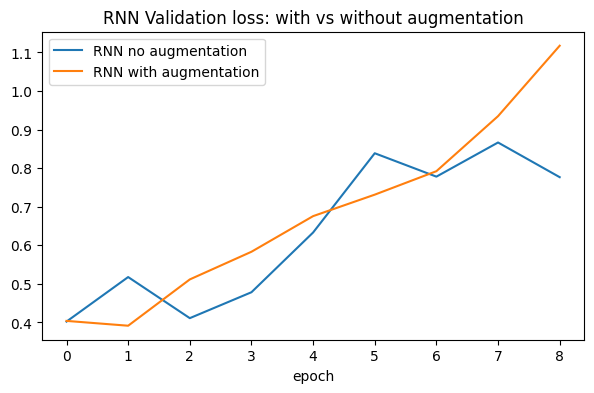

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(hist_rnn_noaug["val_f1"], label="RNN no augmentation")
plt.plot(hist_rnn_aug["val_f1"], label="RNN with augmentation")
plt.title("RNN Validation F1: with vs without augmentation")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(hist_rnn_noaug["val_loss"], label="RNN no augmentation")
plt.plot(hist_rnn_aug["val_loss"], label="RNN with augmentation")
plt.title("RNN Validation loss: with vs without augmentation")
plt.xlabel("epoch")
plt.legend()
plt.show()


In [ ]:
test_loss_rnn_noaug, test_acc_rnn_noaug, test_f1_rnn_noaug = evaluate_model(rnn_noaug, test_loader)
test_loss_rnn_aug,   test_acc_rnn_aug,   test_f1_rnn_aug   = evaluate_model(rnn_aug,   test_loader)

print("RNN NO-AUG  TEST | loss={:.4f} acc={:.4f} f1={:.4f}".format(test_loss_rnn_noaug, test_acc_rnn_noaug, test_f1_rnn_noaug))
print("RNN WITH-AUG TEST | loss={:.4f} acc={:.4f} f1={:.4f}".format(test_loss_rnn_aug,   test_acc_rnn_aug,   test_f1_rnn_aug))


RNN NO-AUG  TEST | loss=0.4984 acc=0.8075 f1=0.8243
RNN WITH-AUG TEST | loss=0.5521 acc=0.8003 f1=0.8296


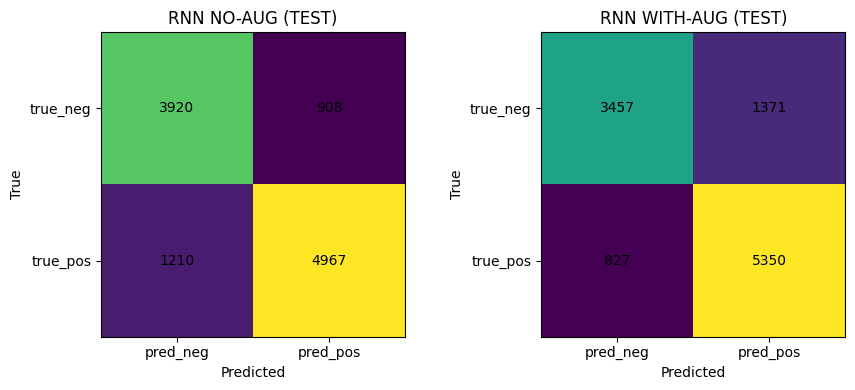

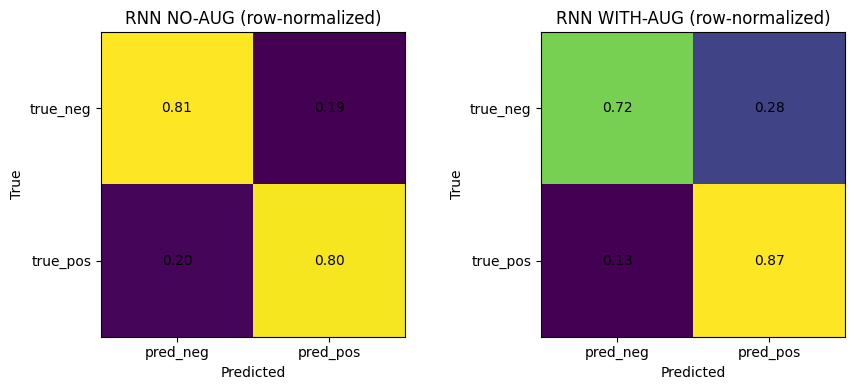

RNN NO-AUG report:
               precision    recall  f1-score   support

    negative       0.76      0.81      0.79      4828
    positive       0.85      0.80      0.82      6177

    accuracy                           0.81     11005
   macro avg       0.80      0.81      0.81     11005
weighted avg       0.81      0.81      0.81     11005

RNN WITH-AUG report:
               precision    recall  f1-score   support

    negative       0.81      0.72      0.76      4828
    positive       0.80      0.87      0.83      6177

    accuracy                           0.80     11005
   macro avg       0.80      0.79      0.79     11005
weighted avg       0.80      0.80      0.80     11005

F1 binary  | no-aug: 0.8243 | aug: 0.8296
F1 macro   | no-aug: 0.8058 | aug: 0.7942


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import numpy as np
import matplotlib.pyplot as plt
import torch

def get_preds(model, loader):
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            lengths = get_lengths(xb, PAD_IDX).to(device)
            logits = model(xb, lengths)
            p = torch.argmax(logits, dim=1)
            preds.append(p.cpu().numpy())
            true.append(yb.cpu().numpy())
    return np.concatenate(true), np.concatenate(preds)

y_true, p_rnn_noaug = get_preds(rnn_noaug, test_loader)
_,      p_rnn_aug   = get_preds(rnn_aug,   test_loader)

cm_noaug = confusion_matrix(y_true, p_rnn_noaug)
cm_aug   = confusion_matrix(y_true, p_rnn_aug)

fig, axes = plt.subplots(1, 2, figsize=(9,4))

axes[0].imshow(cm_noaug)
axes[0].set_title("RNN NO-AUG (TEST)")
axes[0].set_xticks([0,1]); axes[0].set_xticklabels(["pred_neg","pred_pos"])
axes[0].set_yticks([0,1]); axes[0].set_yticklabels(["true_neg","true_pos"])
for i in range(2):
    for j in range(2):
        axes[0].text(j, i, cm_noaug[i,j], ha="center", va="center")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")

axes[1].imshow(cm_aug)
axes[1].set_title("RNN WITH-AUG (TEST)")
axes[1].set_xticks([0,1]); axes[1].set_xticklabels(["pred_neg","pred_pos"])
axes[1].set_yticks([0,1]); axes[1].set_yticklabels(["true_neg","true_pos"])
for i in range(2):
    for j in range(2):
        axes[1].text(j, i, cm_aug[i,j], ha="center", va="center")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

cm_noaug_norm = cm_noaug / cm_noaug.sum(axis=1, keepdims=True)
cm_aug_norm   = cm_aug   / cm_aug.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(9,4))

axes[0].imshow(cm_noaug_norm)
axes[0].set_title("RNN NO-AUG (row-normalized)")
axes[0].set_xticks([0,1]); axes[0].set_xticklabels(["pred_neg","pred_pos"])
axes[0].set_yticks([0,1]); axes[0].set_yticklabels(["true_neg","true_pos"])
for i in range(2):
    for j in range(2):
        axes[0].text(j, i, f"{cm_noaug_norm[i,j]:.2f}", ha="center", va="center")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")

axes[1].imshow(cm_aug_norm)
axes[1].set_title("RNN WITH-AUG (row-normalized)")
axes[1].set_xticks([0,1]); axes[1].set_xticklabels(["pred_neg","pred_pos"])
axes[1].set_yticks([0,1]); axes[1].set_yticklabels(["true_neg","true_pos"])
for i in range(2):
    for j in range(2):
        axes[1].text(j, i, f"{cm_aug_norm[i,j]:.2f}", ha="center", va="center")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

print("RNN NO-AUG report:\n", classification_report(y_true, p_rnn_noaug, target_names=["negative","positive"]))
print("RNN WITH-AUG report:\n", classification_report(y_true, p_rnn_aug,   target_names=["negative","positive"]))

print("F1 binary  | no-aug:", round(f1_score(y_true, p_rnn_noaug), 4), "| aug:", round(f1_score(y_true, p_rnn_aug), 4))
print("F1 macro   | no-aug:", round(f1_score(y_true, p_rnn_noaug, average="macro"), 4),
      "| aug:", round(f1_score(y_true, p_rnn_aug, average="macro"), 4))


## 4. LSTM

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, pad_idx,
                 hidden_size=128, num_layers=1, dropout=0.3,
                 bidirectional=False, pooling="last"):
        super().__init__()
        vocab_size, emb_dim = embedding_matrix.shape

        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
        self.embedding.weight.requires_grad = True

        self.bidirectional = bidirectional
        self.pooling = pooling

        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=(dropout if num_layers > 1 else 0.0),
            bidirectional=bidirectional
        )

        out_dim = hidden_size * (2 if bidirectional else 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Sequential(
            nn.Linear(out_dim, out_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(out_dim, 2)
        )

        self.loss_fn = None

    def forward(self, x, lengths):
        emb = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out, (h_n, c_n) = self.lstm(packed)

        if self.pooling == "last":
            if self.bidirectional:
                fwd = h_n[-2]
                bwd = h_n[-1]
                rep = torch.cat([fwd, bwd], dim=1)
            else:
                rep = h_n[-1]

        else:
            out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True, total_length=x.size(1))
            mask = (x != PAD_IDX).unsqueeze(-1)
            out = out * mask

            if self.pooling == "mean":
                denom = mask.sum(dim=1).clamp(min=1)
                rep = out.sum(dim=1) / denom
            elif self.pooling == "max":
                out_masked = out.clone()
                out_masked[~mask.expand_as(out_masked)] = -1e9
                rep = out_masked.max(dim=1).values
            else:
                raise ValueError("pooling must be one of: last/mean/max")

        rep = self.dropout(rep)
        logits = self.fc(rep)
        return logits


In [49]:
def fit_lstm(config, max_epochs=30, lr=1e-3, weight_decay=1e-4, patience=6, clip=1.0, verbose=True):
    y_np = y_train.cpu().numpy()
    neg = (y_np == 0).sum()
    pos = (y_np == 1).sum()
    w0 = (neg + pos) / (2.0 * neg)
    w1 = (neg + pos) / (2.0 * pos)
    class_weights = torch.tensor([w0, w1], dtype=torch.float32, device=device)

    model = LSTMClassifier(
        embedding_matrix=embedding_matrix,
        pad_idx=PAD_IDX,
        hidden_size=config["hidden_size"],
        num_layers=config["num_layers"],
        dropout=config["dropout"],
        bidirectional=config["bidirectional"],
        pooling=config["pooling"]
    ).to(device)

    model.loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {"train_loss": [], "val_loss": [], "val_acc": [], "val_f1": []}
    best_f1 = -1.0
    best_state = None
    best_epoch = None
    bad_epochs = 0

    for epoch in range(1, max_epochs+1):
        tr_loss = train_one_epoch(model, train_loader, optimizer, clip=clip)
        va_loss, va_acc, va_f1 = evaluate_model(model, val_loader)

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)
        history["val_f1"].append(va_f1)

        if verbose:
            print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | val_acc={va_acc:.4f} | val_f1={va_f1:.4f}")

        if va_f1 > best_f1 + 1e-4:
            best_f1 = va_f1
            best_epoch = epoch
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch} (no val_f1 improvement for {bad_epochs} consecutive epochs).")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    summary = {"config": config, "best_val_f1": float(best_f1), "best_epoch": best_epoch, "epochs_ran": len(history["train_loss"])}
    print("\nSummary:", summary, "\n")
    return model, history, best_f1, summary


In [50]:
lstm_configs = [
    {"name":"lstm_uni_last_h128_l1_d0.3", "hidden_size":128, "num_layers":1, "dropout":0.3, "bidirectional":False, "pooling":"last"},
    {"name":"lstm_uni_mean_h128_l1_d0.3", "hidden_size":128, "num_layers":1, "dropout":0.3, "bidirectional":False, "pooling":"mean"},
    {"name":"lstm_bi_last_h128_l1_d0.3",  "hidden_size":128, "num_layers":1, "dropout":0.3, "bidirectional":True,  "pooling":"last"},
    {"name":"lstm_bi_mean_h128_l1_d0.3",  "hidden_size":128, "num_layers":1, "dropout":0.3, "bidirectional":True,  "pooling":"mean"},
    {"name":"lstm_bi_last_h256_l1_d0.3",  "hidden_size":256, "num_layers":1, "dropout":0.3, "bidirectional":True,  "pooling":"last"},
]


In [51]:
lstm_results = []
lstm_models = {}
lstm_histories = {}
lstm_summaries = {}

for cfg in lstm_configs:
    print("\n", cfg["name"])
    model, hist, best_f1, summary = fit_lstm(cfg, max_epochs=30, lr=1e-3, weight_decay=1e-4, patience=6, clip=1.0)
    lstm_results.append((cfg["name"], best_f1))
    lstm_models[cfg["name"]] = model
    lstm_histories[cfg["name"]] = hist
    lstm_summaries[cfg["name"]] = summary

lstm_sorted = sorted(lstm_results, key=lambda x: x[1], reverse=True)
print("\nLSTM results (sorted by best val F1):")
for name, f1 in lstm_sorted:
    print(f"{name:30s} best_val_f1={f1:.4f}")



 lstm_uni_last_h128_l1_d0.3
Epoch 01 | train_loss=0.5239 | val_loss=0.3764 | val_acc=0.8142 | val_f1=0.8305
Epoch 02 | train_loss=0.2461 | val_loss=0.3107 | val_acc=0.8629 | val_f1=0.8814
Epoch 03 | train_loss=0.1454 | val_loss=0.4015 | val_acc=0.8576 | val_f1=0.8787
Epoch 04 | train_loss=0.0850 | val_loss=0.4495 | val_acc=0.8746 | val_f1=0.8944
Epoch 05 | train_loss=0.0611 | val_loss=0.5735 | val_acc=0.8788 | val_f1=0.9017
Epoch 06 | train_loss=0.0454 | val_loss=0.5450 | val_acc=0.8467 | val_f1=0.8679
Epoch 07 | train_loss=0.0247 | val_loss=1.0383 | val_acc=0.8614 | val_f1=0.8927
Epoch 08 | train_loss=0.0247 | val_loss=0.8472 | val_acc=0.8414 | val_f1=0.8749
Epoch 09 | train_loss=0.0284 | val_loss=0.7202 | val_acc=0.8595 | val_f1=0.8817
Epoch 10 | train_loss=0.0200 | val_loss=0.7525 | val_acc=0.8335 | val_f1=0.8604
Epoch 11 | train_loss=0.0137 | val_loss=0.9027 | val_acc=0.8550 | val_f1=0.8810
Early stopping at epoch 11 (no val_f1 improvement for 6 consecutive epochs).

Summary: {'co

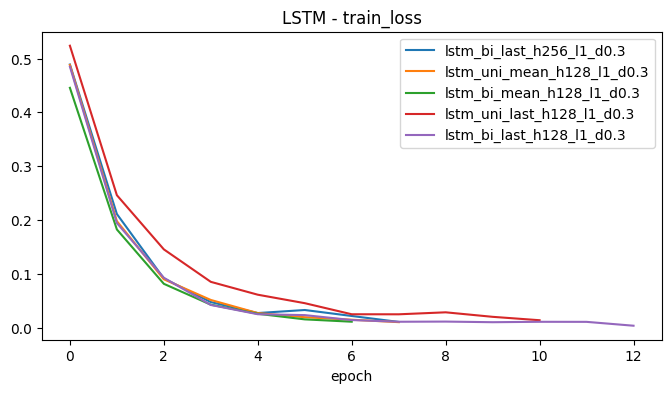

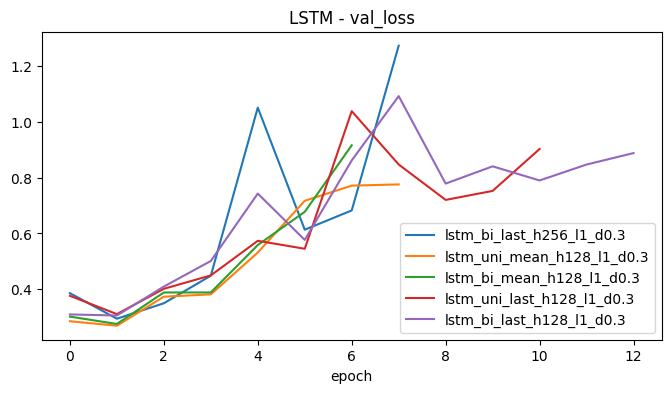

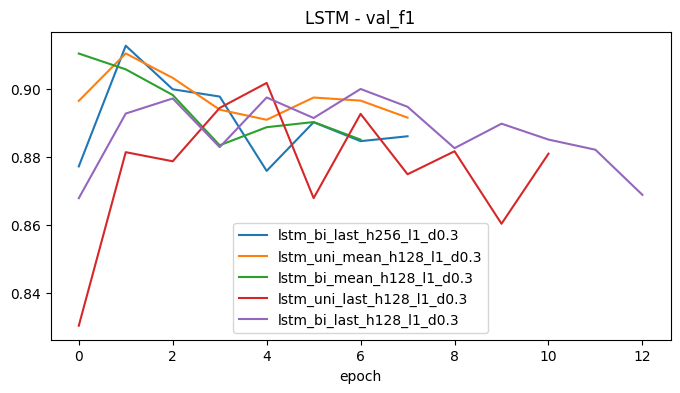

In [ ]:
import matplotlib.pyplot as plt

def plot_lstm_histories(lstm_sorted, lstm_histories, metric="val_f1", top_k=None):
    plt.figure(figsize=(8,4))
    items = lstm_sorted if top_k is None else lstm_sorted[:top_k]
    for name, _ in items:
        plt.plot(lstm_histories[name][metric], label=name)
    plt.title(f"LSTM - {metric}")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

plot_lstm_histories(lstm_sorted, lstm_histories, metric="train_loss", top_k=5)
plot_lstm_histories(lstm_sorted, lstm_histories, metric="val_loss", top_k=5)
plot_lstm_histories(lstm_sorted, lstm_histories, metric="val_f1", top_k=5)


Alegem cea mai buna configuratie ca sa facem partea de test

In [ ]:
best_lstm_name = lstm_sorted[0][0]
best_lstm_model = lstm_models[best_lstm_name]

test_ds = TextDataset(test_padded, y_test, np.arange(len(y_test)))
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

test_loss, test_acc, test_f1 = evaluate_model(best_lstm_model, test_loader)

print("BEST LSTM:", best_lstm_name)
print(f"TEST | loss={test_loss:.4f} | acc={test_acc:.4f} | f1={test_f1:.4f}")


BEST LSTM: lstm_bi_last_h256_l1_d0.3
TEST | loss=0.3538 | acc=0.8509 | f1=0.8628


F1 (binary): 0.8628
F1 (macro):  0.8498
              precision    recall  f1-score   support

    negative       0.81      0.87      0.84      4828
    positive       0.89      0.84      0.86      6177

    accuracy                           0.85     11005
   macro avg       0.85      0.85      0.85     11005
weighted avg       0.85      0.85      0.85     11005



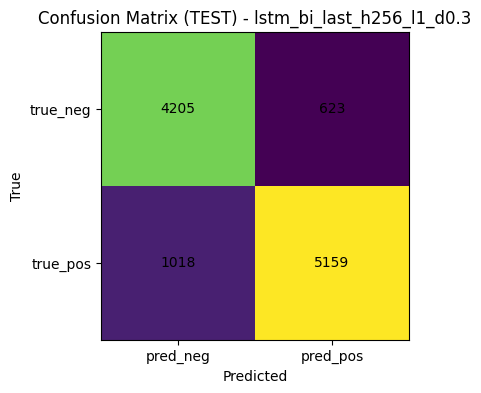

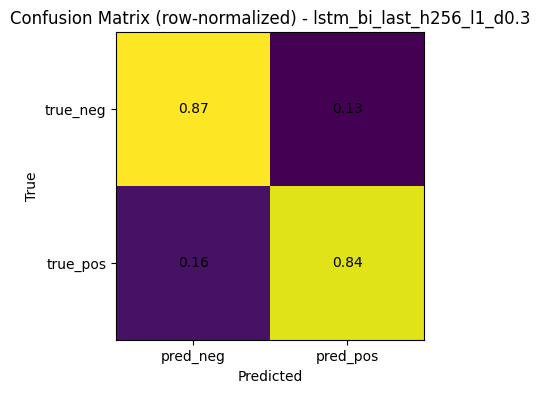

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np
import matplotlib.pyplot as plt
import torch

best_lstm_model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        lengths = get_lengths(xb, PAD_IDX).to(device)
        logits = best_lstm_model(xb, lengths)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_true.append(yb.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_true  = np.concatenate(all_true)

print("F1 (binary):", round(f1_score(all_true, all_preds), 4))
print("F1 (macro): ", round(f1_score(all_true, all_preds, average="macro"), 4))
print(classification_report(all_true, all_preds, target_names=["negative","positive"]))

cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(4,4))
plt.imshow(cm)
plt.title(f"Confusion Matrix (TEST) - {best_lstm_name}")
plt.xticks([0,1], ["pred_neg","pred_pos"])
plt.yticks([0,1], ["true_neg","true_pos"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

cm_norm = cm / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(4,4))
plt.imshow(cm_norm)
plt.title(f"Confusion Matrix (row-normalized) - {best_lstm_name}")
plt.xticks([0,1], ["pred_neg","pred_pos"])
plt.yticks([0,1], ["true_neg","true_pos"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [55]:
import pandas as pd

lstm_summary_df = pd.DataFrame([
    {
        "name": name,
        "best_val_f1": lstm_summaries[name]["best_val_f1"],
        "best_epoch": lstm_summaries[name]["best_epoch"],
        "epochs_ran": lstm_summaries[name]["epochs_ran"],
        "hidden": lstm_summaries[name]["config"]["hidden_size"],
        "layers": lstm_summaries[name]["config"]["num_layers"],
        "dropout": lstm_summaries[name]["config"]["dropout"],
        "bidir": lstm_summaries[name]["config"]["bidirectional"],
        "pooling": lstm_summaries[name]["config"]["pooling"],
    }
    for name in lstm_summaries
]).sort_values("best_val_f1", ascending=False)

lstm_summary_df


,name,best_val_f1,best_epoch,epochs_ran,hidden,layers,dropout,bidir,pooling
4,lstm_bi_last_h256_l1_d0.3,0.912669,2,8,256,1,0.3,True,last
1,lstm_uni_mean_h128_l1_d0.3,0.910401,2,8,128,1,0.3,False,mean
3,lstm_bi_mean_h128_l1_d0.3,0.910377,1,7,128,1,0.3,True,mean
0,lstm_uni_last_h128_l1_d0.3,0.901745,5,11,128,1,0.3,False,last
2,lstm_bi_last_h128_l1_d0.3,0.899970,7,13,128,1,0.3,True,last


Pentru cea mai buna configuratie,vom incerca sa reantrenam, dar de data asta si cu augmentare

In [56]:
best_lstm_cfg = {
    "name": "lstm_bi_mean_h128_l1_d0.3",
    "hidden_size": 128,
    "num_layers": 1,
    "dropout": 0.3,
    "bidirectional": True,
    "pooling": "mean"
}


In [57]:
import random, numpy as np, torch

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

lstm_noaug, hist_lstm_noaug, best_f1_lstm_noaug, summ_lstm_noaug = fit_lstm(
    best_lstm_cfg,
    max_epochs=30,
    lr=1e-3,
    weight_decay=1e-4,
    patience=6,
    clip=1.0
)
print("Best val F1 (LSTM no-aug):", best_f1_lstm_noaug)


Epoch 01 | train_loss=0.4523 | val_loss=0.2679 | val_acc=0.8844 | val_f1=0.9024
Epoch 02 | train_loss=0.1825 | val_loss=0.2887 | val_acc=0.8875 | val_f1=0.9094
Epoch 03 | train_loss=0.0843 | val_loss=0.3373 | val_acc=0.8610 | val_f1=0.8791
Epoch 04 | train_loss=0.0406 | val_loss=0.5523 | val_acc=0.8727 | val_f1=0.8992
Epoch 05 | train_loss=0.0215 | val_loss=0.6216 | val_acc=0.8467 | val_f1=0.8656
Epoch 06 | train_loss=0.0173 | val_loss=0.6394 | val_acc=0.8746 | val_f1=0.8982
Epoch 07 | train_loss=0.0105 | val_loss=0.8128 | val_acc=0.8678 | val_f1=0.8925
Epoch 08 | train_loss=0.0119 | val_loss=0.7062 | val_acc=0.8671 | val_f1=0.8917
Early stopping at epoch 8 (no val_f1 improvement for 6 consecutive epochs).

Summary: {'config': {'name': 'lstm_bi_mean_h128_l1_d0.3', 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.3, 'bidirectional': True, 'pooling': 'mean'}, 'best_val_f1': 0.9094224924012158, 'best_epoch': 2, 'epochs_ran': 8} 

Best val F1 (LSTM no-aug): 0.9094224924012158


In [ ]:
print("Have train_loader_aug?", "train_loader_aug" in globals())

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

orig_train_loader = train_loader
train_loader = train_loader_aug

lstm_aug, hist_lstm_aug, best_f1_lstm_aug, summ_lstm_aug = fit_lstm(
    best_lstm_cfg,
    max_epochs=30,
    lr=1e-3,
    weight_decay=1e-4,
    patience=6,
    clip=1.0
)

train_loader = orig_train_loader

print("Best val F1 (LSTM with-aug):", best_f1_lstm_aug)


Have train_loader_aug? True
Epoch 01 | train_loss=0.3928 | val_loss=0.2860 | val_acc=0.8829 | val_f1=0.9046
Epoch 02 | train_loss=0.1304 | val_loss=0.3257 | val_acc=0.8799 | val_f1=0.9032
Epoch 03 | train_loss=0.0595 | val_loss=0.5067 | val_acc=0.8705 | val_f1=0.8992
Epoch 04 | train_loss=0.0300 | val_loss=0.4924 | val_acc=0.8682 | val_f1=0.8925
Epoch 05 | train_loss=0.0183 | val_loss=0.6279 | val_acc=0.8663 | val_f1=0.8896
Epoch 06 | train_loss=0.0108 | val_loss=0.7726 | val_acc=0.8701 | val_f1=0.8958
Epoch 07 | train_loss=0.0117 | val_loss=0.6599 | val_acc=0.8693 | val_f1=0.8922
Early stopping at epoch 7 (no val_f1 improvement for 6 consecutive epochs).

Summary: {'config': {'name': 'lstm_bi_mean_h128_l1_d0.3', 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.3, 'bidirectional': True, 'pooling': 'mean'}, 'best_val_f1': 0.9046153846153846, 'best_epoch': 1, 'epochs_ran': 7} 

Best val F1 (LSTM with-aug): 0.9046153846153846


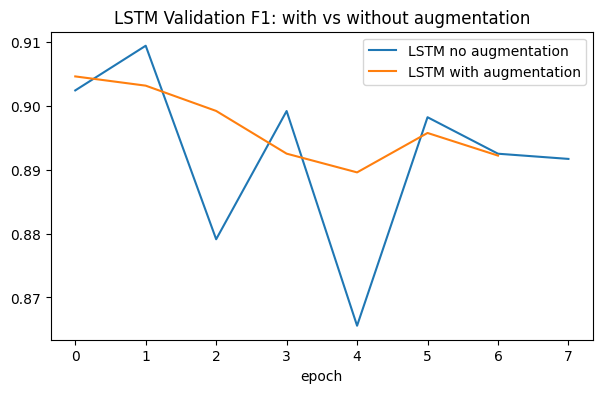

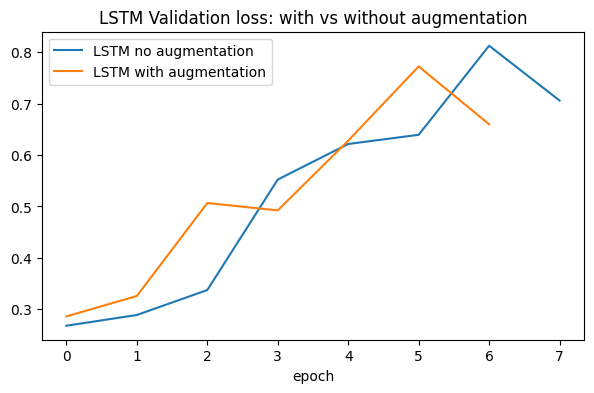

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(hist_lstm_noaug["val_f1"], label="LSTM no augmentation")
plt.plot(hist_lstm_aug["val_f1"], label="LSTM with augmentation")
plt.title("LSTM Validation F1: with vs without augmentation")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(hist_lstm_noaug["val_loss"], label="LSTM no augmentation")
plt.plot(hist_lstm_aug["val_loss"], label="LSTM with augmentation")
plt.title("LSTM Validation loss: with vs without augmentation")
plt.xlabel("epoch")
plt.legend()
plt.show()


In [ ]:
test_ds = TextDataset(test_padded, y_test, np.arange(len(y_test)))
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

test_loss_noaug, test_acc_noaug, test_f1_noaug = evaluate_model(lstm_noaug, test_loader)
test_loss_aug,   test_acc_aug,   test_f1_aug   = evaluate_model(lstm_aug,   test_loader)

print("LSTM NO-AUG  TEST | loss={:.4f} acc={:.4f} f1={:.4f}".format(test_loss_noaug, test_acc_noaug, test_f1_noaug))
print("LSTM WITH-AUG TEST | loss={:.4f} acc={:.4f} f1={:.4f}".format(test_loss_aug,   test_acc_aug,   test_f1_aug))


LSTM NO-AUG  TEST | loss=0.3455 acc=0.8539 f1=0.8699
LSTM WITH-AUG TEST | loss=0.3366 acc=0.8529 f1=0.8678


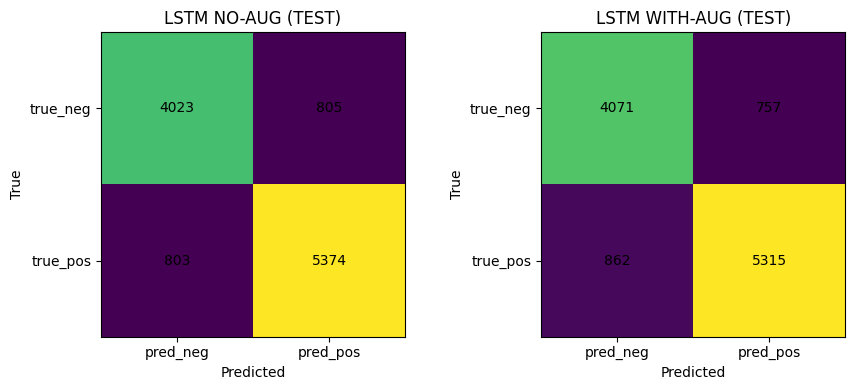

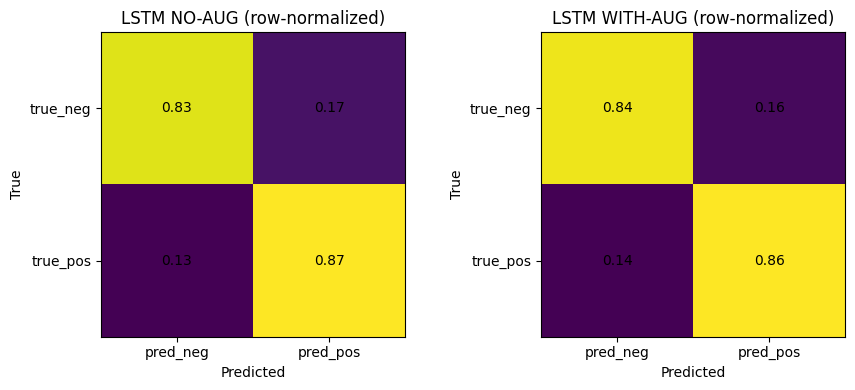

NO-AUG report:
               precision    recall  f1-score   support

    negative       0.83      0.83      0.83      4828
    positive       0.87      0.87      0.87      6177

    accuracy                           0.85     11005
   macro avg       0.85      0.85      0.85     11005
weighted avg       0.85      0.85      0.85     11005

WITH-AUG report:
               precision    recall  f1-score   support

    negative       0.83      0.84      0.83      4828
    positive       0.88      0.86      0.87      6177

    accuracy                           0.85     11005
   macro avg       0.85      0.85      0.85     11005
weighted avg       0.85      0.85      0.85     11005

F1 binary | no-aug: 0.8699 | aug: 0.8678
F1 macro  | no-aug: 0.8516 | aug: 0.851


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import numpy as np
import matplotlib.pyplot as plt
import torch

if "test_loader" not in globals():
    test_ds = TextDataset(test_padded, y_test, np.arange(len(y_test)))
    test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

def get_preds(model, loader):
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            lengths = get_lengths(xb, PAD_IDX).to(device)
            logits = model(xb, lengths)
            p = torch.argmax(logits, dim=1)
            preds.append(p.cpu().numpy())
            true.append(yb.cpu().numpy())
    return np.concatenate(true), np.concatenate(preds)

y_true, p_noaug = get_preds(lstm_noaug, test_loader)
_,      p_aug   = get_preds(lstm_aug,   test_loader)

cm_noaug = confusion_matrix(y_true, p_noaug)
cm_aug   = confusion_matrix(y_true, p_aug)

fig, axes = plt.subplots(1, 2, figsize=(9,4))

axes[0].imshow(cm_noaug)
axes[0].set_title("LSTM NO-AUG (TEST)")
axes[0].set_xticks([0,1]); axes[0].set_xticklabels(["pred_neg","pred_pos"])
axes[0].set_yticks([0,1]); axes[0].set_yticklabels(["true_neg","true_pos"])
for i in range(2):
    for j in range(2):
        axes[0].text(j, i, cm_noaug[i,j], ha="center", va="center")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")

axes[1].imshow(cm_aug)
axes[1].set_title("LSTM WITH-AUG (TEST)")
axes[1].set_xticks([0,1]); axes[1].set_xticklabels(["pred_neg","pred_pos"])
axes[1].set_yticks([0,1]); axes[1].set_yticklabels(["true_neg","true_pos"])
for i in range(2):
    for j in range(2):
        axes[1].text(j, i, cm_aug[i,j], ha="center", va="center")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

cm_noaug_norm = cm_noaug / cm_noaug.sum(axis=1, keepdims=True)
cm_aug_norm   = cm_aug   / cm_aug.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(9,4))

axes[0].imshow(cm_noaug_norm)
axes[0].set_title("LSTM NO-AUG (row-normalized)")
axes[0].set_xticks([0,1]); axes[0].set_xticklabels(["pred_neg","pred_pos"])
axes[0].set_yticks([0,1]); axes[0].set_yticklabels(["true_neg","true_pos"])
for i in range(2):
    for j in range(2):
        axes[0].text(j, i, f"{cm_noaug_norm[i,j]:.2f}", ha="center", va="center")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")

axes[1].imshow(cm_aug_norm)
axes[1].set_title("LSTM WITH-AUG (row-normalized)")
axes[1].set_xticks([0,1]); axes[1].set_xticklabels(["pred_neg","pred_pos"])
axes[1].set_yticks([0,1]); axes[1].set_yticklabels(["true_neg","true_pos"])
for i in range(2):
    for j in range(2):
        axes[1].text(j, i, f"{cm_aug_norm[i,j]:.2f}", ha="center", va="center")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

print("NO-AUG report:\n", classification_report(y_true, p_noaug, target_names=["negative","positive"]))
print("WITH-AUG report:\n", classification_report(y_true, p_aug,   target_names=["negative","positive"]))

print("F1 binary | no-aug:", round(f1_score(y_true, p_noaug), 4), "| aug:", round(f1_score(y_true, p_aug), 4))
print("F1 macro  | no-aug:", round(f1_score(y_true, p_noaug, average="macro"), 4),
      "| aug:", round(f1_score(y_true, p_aug, average="macro"), 4))
